# EmotionX
Best model for EmotionPush dataset <br>
Author: Andrew Nguyen <br>
Date: 9/6/2019 

Summary: <br>
Using the target utterance only (utterance2) <br>
-> feature selection using TFIDF <br>
-> one hot encoding <br>
-> linearSVM

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import sys
sys.path
sys.path.append('../')

# custom functs
from src.features import build_features
from src.visualization.visualize import plot_confusion_matrix
from src.utils.utils import get_project_root

In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy

import random
from collections import Counter

from nltk import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Binarizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.multiclass import unique_labels

## Prepare data

In [4]:
ROOT_PATH = get_project_root()
TRAIN_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.train.json"
DEV_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.dev.json"
TEST_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.test.json"

df_train = build_features.to_df(TRAIN_PATH)
df_dev = build_features.to_df(DEV_PATH)
df_test = build_features.to_df(TEST_PATH)

In [5]:
df_train["split"] = "train"
df_dev["split"] = "dev"
df_test["split"] = "test"

In [6]:
# concat df
df = pd.concat([df_train, df_dev, df_test], ignore_index=True)
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split
0,4001000,0,NaN,neutral,neutral,NaN,Sorry to bother you but do you have the 270 te...,What's it called,train
1,4000010,0,neutral,neutral,neutral,Sorry to bother you but do you have the 270 te...,What's it called,Digital design and principles I think,train
2,5000000,0,neutral,neutral,neutral,What's it called,Digital design and principles I think,I don't think so?,train
3,3000020,0,neutral,neutral,neutral,Digital design and principles I think,I don't think so?,I could be wrong,train
4,5000000,0,neutral,neutral,neutral,I don't think so?,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,train
5,3020000,0,neutral,neutral,neutral,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,train
6,5000000,0,neutral,neutral,neutral,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,*book,train
7,5000000,0,neutral,neutral,neutral,You don't need the boom,*book,"If I do have it, I never used it",train
8,4000010,0,neutral,neutral,non-neutral,*book,"If I do have it, I never used it",But you had a good professor,train
9,2110100,0,neutral,non-neutral,neutral,"If I do have it, I never used it",But you had a good professor,I mean you can use the notes,train


In [7]:
# simplify emotion labels
df = df[df.emotion2.isin(["neutral", "joy", "sadness", "anger"])]

In [8]:
df = df.reset_index(drop=True)

## Preprocess

In [9]:
# make nan utterances -> empty strings
df.utterance1 = df.utterance1.fillna("")
df.utterance3 = df.utterance3.fillna("")

In [10]:
# preappend utterance 1 + utterance 2 with number
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

def preappend(sent, num):
    words = tokenizer.tokenize(sent)
    
    # remove stop words
    stopWords = set(stopwords.words('english'))
    words = [ w for w in words if w not in stopWords]
    
    words = [ num + w for w in words]
    return words

df.utterance1 = df.utterance1.apply(lambda x: preappend(x, "1_"))
df.utterance2 = df.utterance2.apply(lambda x: preappend(x, "2_"))
df.utterance3 = df.utterance3.apply(lambda x: preappend(x, "3_"))

In [11]:
# append utt1 and utt2 arrays together
temp = df[["utterance1", "utterance2"]].values.tolist()
temp = [ t[0] + t[1] for t in temp]
df["utterance12"] = temp

## TFIDF 

In [12]:
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split,utterance12
0,4001000,0,NaN,neutral,neutral,[],"[2_sorry, 2_bother, 2_270, 2_textbook, 2_?]","[3_what's, 3_called]",train,"[2_sorry, 2_bother, 2_270, 2_textbook, 2_?]"
1,4000010,0,neutral,neutral,neutral,"[1_sorry, 1_bother, 1_270, 1_textbook, 1_?]","[2_what's, 2_called]","[3_digital, 3_design, 3_principles, 3_think]",train,"[1_sorry, 1_bother, 1_270, 1_textbook, 1_?, 2_..."
2,5000000,0,neutral,neutral,neutral,"[1_what's, 1_called]","[2_digital, 2_design, 2_principles, 2_think]","[3_think, 3_?]",train,"[1_what's, 1_called, 2_digital, 2_design, 2_pr..."
3,3000020,0,neutral,neutral,neutral,"[1_digital, 1_design, 1_principles, 1_think]","[2_think, 2_?]","[3_could, 3_wrong]",train,"[1_digital, 1_design, 1_principles, 1_think, 2..."
4,5000000,0,neutral,neutral,neutral,"[1_think, 1_?]","[2_could, 2_wrong]","[3_ok, 3_that's, 3_fine, 3_., 3_i'm, 3_trying,...",train,"[1_think, 1_?, 2_could, 2_wrong]"
5,3020000,0,neutral,neutral,neutral,"[1_could, 1_wrong]","[2_ok, 2_that's, 2_fine, 2_., 2_i'm, 2_trying,...","[3_need, 3_boom]",train,"[1_could, 1_wrong, 2_ok, 2_that's, 2_fine, 2_...."
6,5000000,0,neutral,neutral,neutral,"[1_ok, 1_that's, 1_fine, 1_., 1_i'm, 1_trying,...","[2_need, 2_boom]","[3_*, 3_book]",train,"[1_ok, 1_that's, 1_fine, 1_., 1_i'm, 1_trying,..."
7,5000000,0,neutral,neutral,neutral,"[1_need, 1_boom]","[2_*, 2_book]","[3_,, 3_never, 3_used]",train,"[1_need, 1_boom, 2_*, 2_book]"
8,4000010,0,neutral,neutral,non-neutral,"[1_*, 1_book]","[2_,, 2_never, 2_used]","[3_good, 3_professor]",train,"[1_*, 1_book, 2_,, 2_never, 2_used]"
9,5000000,0,non-neutral,neutral,neutral,"[1_good, 1_professor]","[2_mean, 2_use, 2_notes]","[3_tells, 3_everything, 3_need, 3_know]",train,"[1_good, 1_professor, 2_mean, 2_use, 2_notes]"


In [13]:
# get vocab
ll = df.utterance2.values.tolist()

shared_vocab = set()
for l in ll:
    shared_vocab.update(l)

In [14]:
counts_df = pd.DataFrame(columns=list(shared_vocab), index = ["anger", "joy", "neutral", "sadness"])
counts_df = counts_df.fillna(0)

## Counting the number of occurances of each token in the corpus of each class
for i, tokens in enumerate(df['utterance2']):
    for word in tokens:
        if word in shared_vocab:
            labl =  df['emotion2'][i]
            counts_df[word][labl]+=1

In [15]:
tfidf = TfidfTransformer()

X_tfidf = tfidf.fit_transform(counts_df.values).toarray()

In [16]:
word_score = []
word_emote = []
for x in zip(*X_tfidf):
    y = [('angry', x[0]), ('joy', x[1]), ('neutral', x[2]), ('sadness', x[3])]
    y = sorted(y, key=lambda x: x[1])
    word_score.append(y[3][1] - y[2][1])
    word_emote.append(y[3][0])

In [17]:
rank = list(zip(shared_vocab, word_score, word_emote))

In [18]:
rank = sorted(rank, key=lambda x:x[1], reverse=True)
rank

[('2_:(', 0.502079771972663, 'sadness'),
 ('2_lol', 0.4576399377077043, 'joy'),
 ('2_fuck', 0.4127288579377417, 'angry'),
 ('2_sorry', 0.37898683383660464, 'sadness'),
 ('2_?', 0.35930941807113814, 'neutral'),
 ('2_!', 0.31925842164798146, 'joy'),
 ('2_haha', 0.2984921423202473, 'joy'),
 ('2_love', 0.16165351123754634, 'joy'),
 ("2_i'm", 0.16146601842195032, 'sadness'),
 ('2_:/', 0.155457750772427, 'sadness'),
 ('2_,', 0.1447386834650142, 'neutral'),
 ('2_miss', 0.1439600352847012, 'sadness'),
 ('2_:)', 0.13663764300140646, 'joy'),
 ('2_hate', 0.12766088469436088, 'angry'),
 ('2_poor', 0.1255318133846057, 'sadness'),
 ('2_aw', 0.1221076724494356, 'sadness'),
 ('2_hahaha', 0.10283195277686885, 'joy'),
 ('2_bad', 0.10268464745932974, 'sadness'),
 ('2_rip', 0.1020641145018931, 'sadness'),
 ('2_fucking', 0.10178185686261222, 'angry'),
 ('2_person', 0.10172716321158565, 'neutral'),
 ('2_:D', 0.09432200707236885, 'joy'),
 ('2_sad', 0.09297118866908145, 'sadness'),
 ('2_angry', 0.090125585706

In [19]:
vocab = [ w[0] for w in rank]

## Feature transform (onehot)

In [20]:
X = df.utterance2

def do_nothing(tokens):
    return tokens

#  [1000, 2500, 5000, 10000]:
half = int(len(vocab)/2)
curvocab = vocab[0:1000]

freq = CountVectorizer(tokenizer=do_nothing, vocabulary=curvocab, preprocessor=None, lowercase=False)
X = freq.fit_transform(X)

onehot = Binarizer()
X = onehot.fit_transform(X.toarray())

In [21]:
len(freq.vocabulary_)

1000

##  Train test split

In [22]:
# # X as is from above
y = df.emotion2
split = df.split

In [23]:
trainIdx = split[split.isin(["train", "dev"])].index.tolist()
testIdx = split[split == "test"].index.tolist()

X_train = [X[i] for i in trainIdx]
X_test = [X[i] for i in testIdx]
y_train = [y[i] for i in trainIdx]
y_test = [y[i] for i in testIdx]

## Train and eval on test set

In [24]:
clf = LinearSVC(random_state=0)

In [25]:
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [26]:
# predict
y_pred = clf.predict(X_test)

## Eval

Confusion matrix, without normalization
[[   4    6   27    0]
 [   1  307  148    2]
 [   0   71 1798   13]
 [   2    3   44   38]]


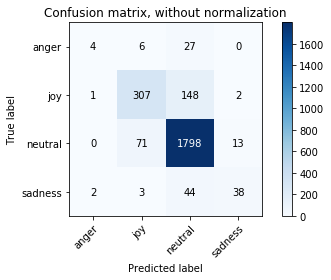

In [27]:
np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[0.11 0.16 0.73 0.  ]
 [0.   0.67 0.32 0.  ]
 [0.   0.04 0.96 0.01]
 [0.02 0.03 0.51 0.44]]


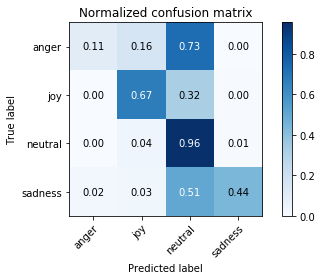

In [29]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.57      0.11      0.18        37
         joy       0.79      0.67      0.73       458
     neutral       0.89      0.96      0.92      1882
     sadness       0.72      0.44      0.54        87

   micro avg       0.87      0.87      0.87      2464
   macro avg       0.74      0.54      0.59      2464
weighted avg       0.86      0.87      0.86      2464



## Micro F1

In [31]:
print("{:.4f}".format(f1_score(y_test, y_pred, average='micro')))

0.8713


## Fit and predict for eval dataset

In [32]:
clf = LinearSVC(random_state=0)
clf.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [37]:
ROOT_PATH = get_project_root()
EVAL_PATH = ROOT_PATH / "data/raw/eval/emotionpush_eval.json"
df_eval = build_features.to_df(EVAL_PATH)

def transform(df):
    # make nan utterances -> empty strings
    df.utterance1 = df.utterance1.fillna("")

    # preappend utterance 1 + utterance 2 with number
    tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

    def preappend(sent, num):
        words = tokenizer.tokenize(sent)

        # remove stop words
        stopWords = set(stopwords.words('english'))
        words = [ w for w in words if w not in stopWords]

        words = [ num + w for w in words]
        return words

    df.utterance1 = df.utterance1.apply(lambda x: preappend(x, "1_"))
    df.utterance2 = df.utterance2.apply(lambda x: preappend(x, "2_"))
    
    # append utt1 and utt2 arrays together
    temp = df[["utterance1", "utterance2"]].values.tolist()
    temp = [ t[0] + t[1] for t in temp]
    df["utterance12"] = temp
    
    return df

df_evall = transform(df_eval)

In [38]:
def x(df,vocab):

    X = df.utterance2

    def do_nothing(tokens):
        return tokens

    #  [1000, 2500, 5000, 10000]:
    curvocab = vocab[0:1000]

    freq = CountVectorizer(tokenizer=do_nothing, vocabulary=curvocab, preprocessor=None, lowercase=False)
    X = freq.fit_transform(X)

    onehot = Binarizer()
    X = onehot.fit_transform(X.toarray())   

#     y = df.emotion2
    return X

X = x(df_evall, vocab)

In [39]:
y_pred = clf.predict(X)

In [40]:
# generate output file
EVAL_PATH = ROOT_PATH / "data/raw/eval/emotionpush_eval.json"
file = EVAL_PATH
if file:
    with open(file, 'r') as f:
        datastore = json.load(f)    

In [41]:
iypred = 0

for i in range(len(datastore)):
    for j in range(len(datastore[i])):
        datastore[i][j]["emotion"] = y_pred[iypred]
        iypred += 1

In [42]:
mydets = {
    "name": "Andrew Nguyen",
    "email": "andrew.nguyen03@adelaide.edu.au"
}

out = [mydets, datastore]

In [43]:
OUT_PATH = ROOT_PATH / "data/processed/emotionpush.submission.json"
filename = OUT_PATH
if filename:
    # Writing JSON data
    with open(filename, 'w') as f:
        json.dump(out, f)